In [2]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from bc_power import utils, hydro
import pandas as pd
from shapely.geometry import Point
import pypsa
import numpy as np
import atlite
import pyomo
import matplotlib.pyplot as plt
import math
# from pypsa.networkclustering import get_clustering_from_busmap
import matplotlib.dates as mdates
import cartopy.crs as ccrs

pyomo.__version__

'6.5.0'

In [100]:
def add_pypsa_dict(network, comp_list):
    for comp_dict in comp_list:
        if comp_dict['bus'] == 'CentralCoast':
            continue
        if comp_dict['bus'] == 'Stikine':
            continue
        if comp_dict['bus'] == "NorthernRockies":
            continue
        network.add(**comp_dict)


In [50]:
for load in n.loads.index:
    print(load)

Alberni-Clayoquot ELC Load
Bulkley-Nechako ELC Load
Capital ELC Load
Cariboo ELC Load
CentralKootenay ELC Load
CentralOkanagan ELC Load
Columbia-Shuswap ELC Load
Comox-Strathcona ELC Load
CowichanValley ELC Load
EastKootenay ELC Load
FraserValley ELC Load
Fraser-FortGeorge ELC Load
Kitimat-Stikine ELC Load
KootenayBoundary ELC Load
GreaterVancouver ELC Load
MountWaddington ELC Load
Nanaimo ELC Load
NorthOkanagan ELC Load
Okanagan-Similkameen ELC Load
PeaceRiver ELC Load
PowellRiver ELC Load
Skeena-QueenCharlotte ELC Load
Squamish-Lillooet ELC Load
SunshineCoast ELC Load
Thompson-Nicola ELC Load
Alberni-Clayoquot_Box truck
Alberni-Clayoquot_Hatchback
Alberni-Clayoquot_Minivan
Alberni-Clayoquot_SUV
Alberni-Clayoquot_Sedan
Alberni-Clayoquot_Sport SUV
Alberni-Clayoquot_Step van
Alberni-Clayoquot_Truck
Bulkley-Nechako_Box truck
Bulkley-Nechako_Hatchback
Bulkley-Nechako_Minivan
Bulkley-Nechako_SUV
Bulkley-Nechako_Sedan
Bulkley-Nechako_Sport SUV
Bulkley-Nechako_Step van
Bulkley-Nechako_Truck


In [3]:
network_path = "/home/pmcwhannel/repos/PyPSA_BC/results/tester_uncoordinated.nc" # cfg['pypsa']['results']
n = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
pypsa.Network.import_from_netcdf(network=n, path=network_path)

INFO:pypsa.io:Imported network tester_uncoordinated.nc has buses, carriers, generators, lines, line_types, links, loads, stores, transformer_types


In [11]:
n.generators_t.p[["BC_BHL_GSS RoR Generator","BC_BDH_GSS RoR Generator"]]

Generator,BC_BHL_GSS RoR Generator,BC_BDH_GSS RoR Generator
snapshot,,
2021-01-01 00:00:00,4.087977,8.111111
2021-01-01 01:00:00,3.977771,8.081634
2021-01-01 02:00:00,4.772810,8.073167
2021-01-01 03:00:00,4.651509,8.072683
2021-01-01 04:00:00,5.003911,8.072683
...,...,...
2021-12-31 19:00:00,3.602131,5.836410
2021-12-31 20:00:00,3.598974,5.836652
2021-12-31 21:00:00,3.596181,5.836652


In [ ]:
n.loads_t.p_set[cols_ev_load].sum(axis=1) + n.loads_t.p_set[cols_ev_load].sum(axis=1)

In [136]:
# Backstop generation
mask = n.generators.index.str.contains("Backstop")
cols = n.generators[mask].index.to_list()
backstop_gen = n.generators_t.p[cols].sum(axis=1)

In [137]:
# Wind generation
mask = n.generators.index.str.contains('Wind')
cols = n.generators[mask].index.to_list()
wind_gen = n.generators_t.p[cols].sum(axis=1)

In [138]:
# RoR Hydro generation
mask = n.generators.index.str.contains('RoR')
cols = n.generators[mask].index.to_list()
ror_gen = n.generators_t.p[cols].sum(axis=1)

In [139]:
# Reserveroir Hydro generation
mask = n.links.index.str.contains('Discharge')
cols = n.links[mask].index.to_list()
hydro_gen = n.links_t.p1[cols].apply(lambda x: abs(x), axis=1).sum(axis=1)

In [161]:
backstop_gen.index[2]
pd.date_range('2021-01-01 02:00:00','2021-01-01 05:00:00', freq='H')

DatetimeIndex(['2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00'],
              dtype='datetime64[ns]', freq='H')

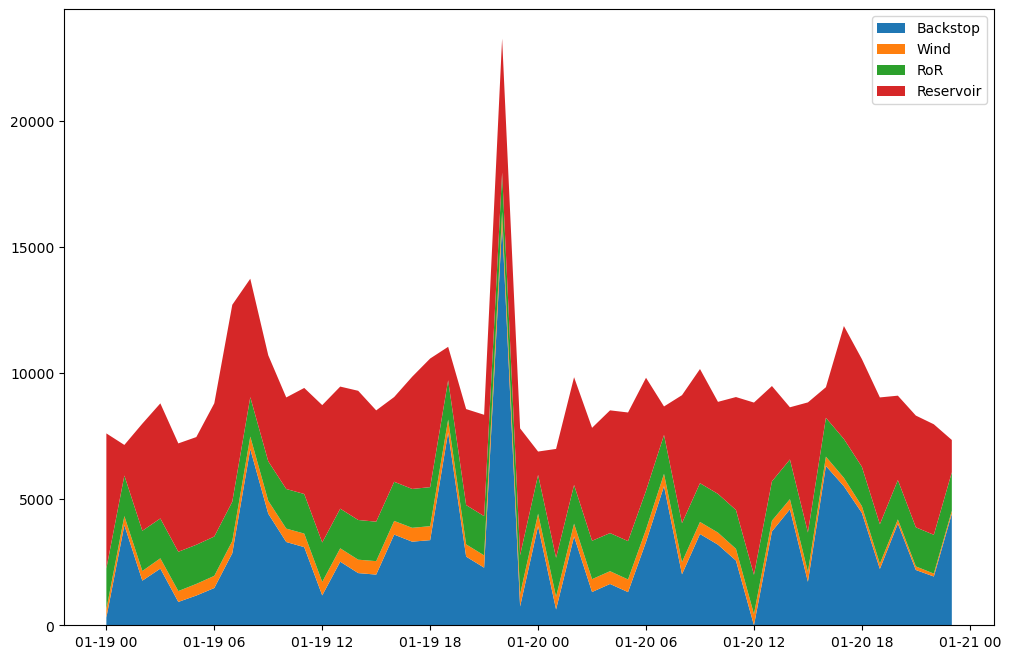

In [170]:
# Stack plot
labels= ["Backstop","Wind","RoR","Reservoir"]
plt.figure(figsize=(12,8))
start = '2021-01-19 00:00:00'
end = '2021-01-20 23:00:00'
plt.stackplot( pd.date_range(start, end, freq='H'), backstop_gen.loc[start:end], wind_gen.loc[start:end], ror_gen.loc[start:end], hydro_gen.loc[start:end], labels=labels)
plt.legend()
plt.savefig('System-Dispatch-2-Day.png')
# plt.ylim([0,20000])


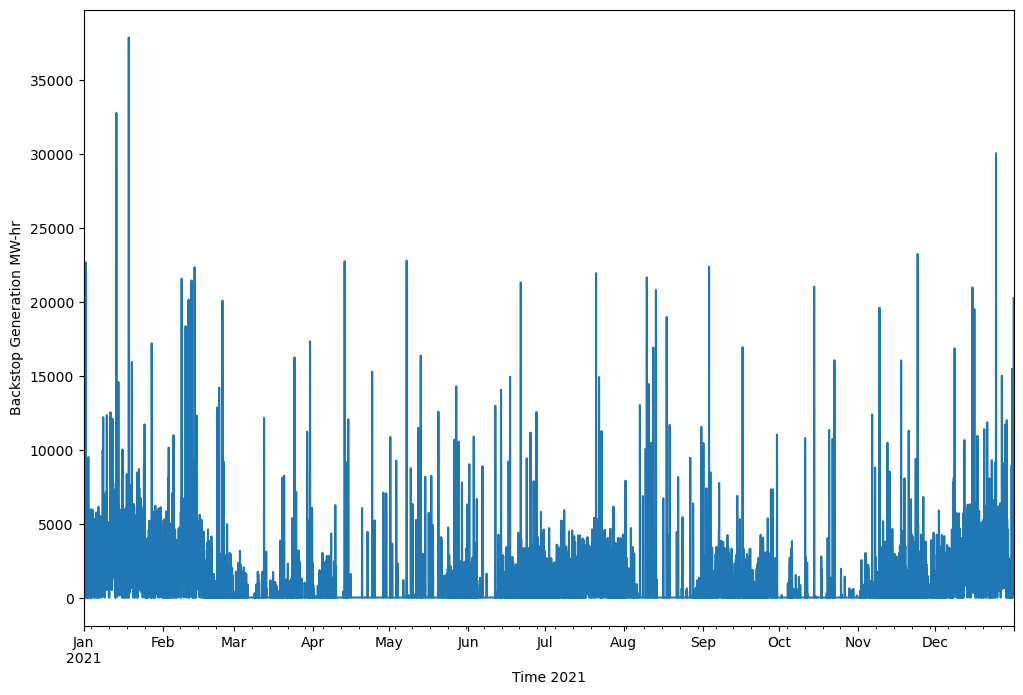

In [98]:
mask = n.generators.index.str.contains("Backstop")
cols = n.generators[mask].index.to_list()
plt.figure(figsize=(12,8))
(n.generators_t.p[cols].sum(axis=1)).plot() # .loc[mask,:]
plt.xlabel('Time 2021')
plt.ylabel('Backstop Generation MW-hr')
plt.savefig('Backstop-Year.png')

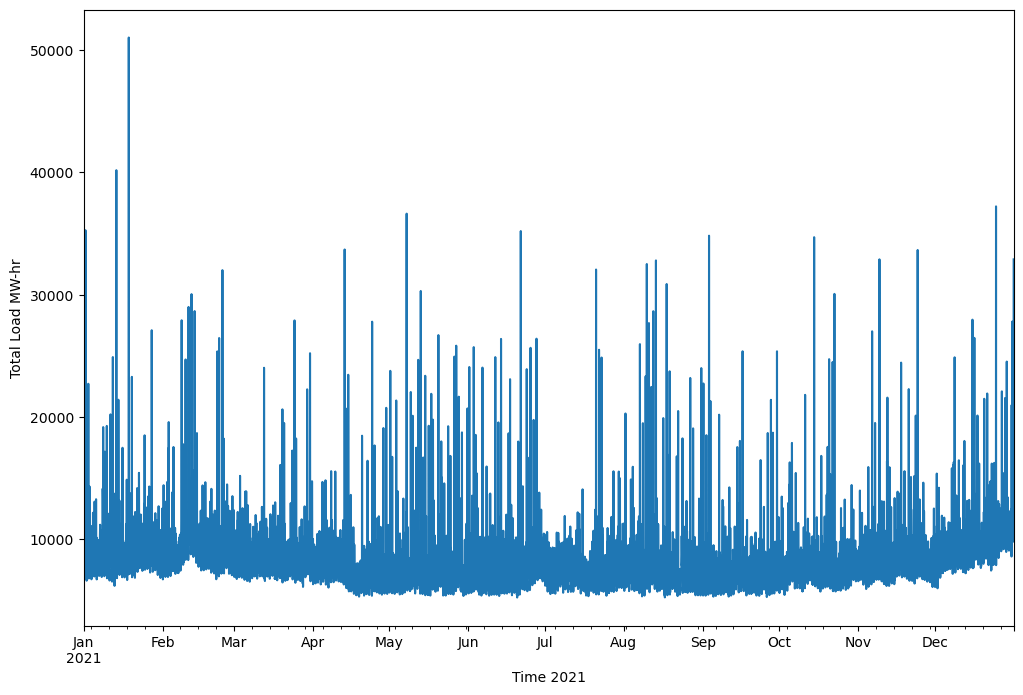

In [94]:
mask = ~ n.loads.index.str.contains("ELC Load")
cols_load = n.loads.loc[~ mask,:].index.to_list()
cols_ev_load = n.loads.loc[mask,:].index.to_list()
plt.figure(figsize=(12,8))
n.loads_t.p_set.sum(axis=1).plot() # .loc[mask,:]
plt.xlabel('Time 2021')
plt.ylabel('Total Load MW-hr')
plt.savefig('Total-Load-Year.png')

In [60]:
geojson_file = "/home/pmcwhannel/repos/PyPSA_BC/data/regions/gadm41_CAN_1.json"
gdf = gpd.read_file(geojson_file)

In [67]:
mask = gdf["NAME_1"] == "BritishColumbia"
gdf.loc[mask,:].geometry.centroid.y.iloc[0]

/tmp/ipykernel_24547/1688874521.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.loc[mask,:].geometry.centroid.y.iloc[0]


54.75339738834036

In [58]:
n.buses

,x,y,type,v_nom,substation_type,carrier,control,generator,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
138_BCAB3_IPT,-114.200000,50.247937,138kV,138.0,IPT,AC,PQ,,,1.0,0.0,inf,
138_BCAB1_IPT,-114.600000,49.735535,138kV,138.0,IPT,AC,PQ,,,1.0,0.0,inf,
138_BCAB4_IPT,-119.700000,58.645250,138kV,138.0,IPT,AC,Slack,,,1.0,0.0,inf,
230_BCUS2_INT,-117.341514,48.997400,230kV,230.0,INT,AC,PQ,,,1.0,0.0,inf,
500_BCUS1_INT,-122.873948,48.970000,500kV,500.0,INT,AC,PQ,,,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kitimat-Stikine,-129.457201,55.740296,,300.0,,AC,PQ,,,1.0,0.0,inf,
Bulkley-Nechako,-125.738993,54.542789,,300.0,,AC,PQ,,,1.0,0.0,inf,
Cariboo,-123.102207,52.343426,,300.0,,AC,PQ,,,1.0,0.0,inf,


### V2G EV Integration

In [36]:
network_path = "/home/pmcwhannel/repos/PyPSA_BC/results/network_debug_cyclic_backstop.nc" # cfg['pypsa']['results']
n = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
pypsa.Network.import_from_netcdf(network=n, path=network_path)

INFO:pypsa.io:Imported network network_debug_cyclic_backstop.nc has buses, carriers, generators, lines, line_types, links, loads, stores, transformer_types


In [37]:
charge_strat = "v2g"
prefix = "/home/pmcwhannel/repos/PyPSA_BC/data/"
ev_bus = utils.read_pickle(prefix + "ev/{}_ev_bus.pickle".format(charge_strat))
ev_load = utils.read_pickle(prefix + "ev/{}_ev_load.pickle".format(charge_strat))
ev_battery = utils.read_pickle(prefix + "ev/{}_ev_battery.pickle".format(charge_strat))
ev_charger = utils.read_pickle(prefix + "ev/{}_ev_charger.pickle".format(charge_strat))
ev_discharger = utils.read_pickle(prefix + "ev/{}_ev_discharger.pickle".format(charge_strat))


In [38]:
for component in ev_bus:
    name = component['name'].split('_')[2]
    c1 = name != "CentralCoast"
    c2 = name != "Stikine"
    c3 = name != "NorthernRockies"
    if c1 and c2 and c3:
        n.add(**component)

for component in ev_load:
    name = component['name'].split('_')[0]
    c1 = name != "CentralCoast"
    c2 = name != "Stikine"
    c3 = name != "NorthernRockies"
    if c1 and c2 and c3:
        n.add(**component)

for component in ev_battery:
    name = component['name'].split('_')[2]
    c1 = name != "CentralCoast"
    c2 = name != "Stikine"
    c3 = name != "NorthernRockies"
    if c1 and c2 and c3:
        n.add(**component)

for component in ev_charger:
    name = component['bus0']
    c1 = name != "CentralCoast"
    c2 = name != "Stikine"
    c3 = name != "NorthernRockies"
    if c1 and c2 and c3:
        n.add(**component)

for component in ev_discharger:
    name = component['bus1']
    c1 = name != "CentralCoast"
    c2 = name != "Stikine"
    c3 = name != "NorthernRockies"
    if c1 and c2 and c3:
        n.add(**component)

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: 

### Testing uncoordinated EV integration

In [43]:
network_path = "/home/pmcwhannel/repos/PyPSA_BC/results/tester_uncoordinated.nc" # cfg['pypsa']['results']

n = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
ev_load_list = utils.read_pickle("/home/pmcwhannel/repos/PyPSA_BC/data/ev/uncoordinated_ev_load.pickle")
pypsa.Network.import_from_netcdf(network=n, path=network_path)


# Add backstop tecnology
# for bus in n.loads.bus.unique():
#     n.add(class_name="Generator",
#                 name='Backstop {}'.format(bus),
#                 bus=bus,
#                 p_nom=0,
#                 marginal_cost=1000,
#                 p_nom_extendable=True
#                 )
    
# add_pypsa_dict(n, ev_load_list)

INFO:pypsa.io:Imported network tester_uncoordinated.nc has buses, carriers, generators, lines, line_types, links, loads, stores, transformer_types


In [52]:
mask = ~ n.loads.index.str.contains("ELC Load")
cols = n.loads[mask].index

In [56]:
n.loads_t.p_set[cols].sum(axis=1).sum()

9270099.654530497

In [116]:
n.optimize(solver_name='gurobi')

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Read LP format model from file /tmp/linopy-problem-f60cz0lr.lp
Reading time = 11.50 seconds
obj: 10196415 rows, 3372625 columns, 18176518 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 10196415 rows, 3372625 columns and 18176518 nonzeros
Model fingerprint: 0x2761d27f
Coefficient statistics:
  Matrix range     [8e-05, 9e+03]
  Objective range  [1e-06, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 1e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 9679576 rows and 2002190 columns (presolve time = 5s) ...
Presolve removed 9734035 rows and 2100455 columns
Presolve time: 9.43s
Presolved: 462380 rows, 1272170 columns, 2593024 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, a

: 

In [107]:
cols = n.generators[n.generators.index.str.contains("Backstop")].index